In [73]:
import matplotlib.pyplot as plt
import sympy as sp
import sympy.printing.latex as latex
import numpy as np

from IPython.display import display,Markdown

Consider the following relationship:

$$A = BX$$

Here, $A$, and $B$ are continuous variables. $X$ is a binary variable.

This is a bilinear constraint as shown in the following graph.

C:\Users\nb5786-A\AppData\Local\Temp\ipykernel_12756\1852828833.py:21: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 11


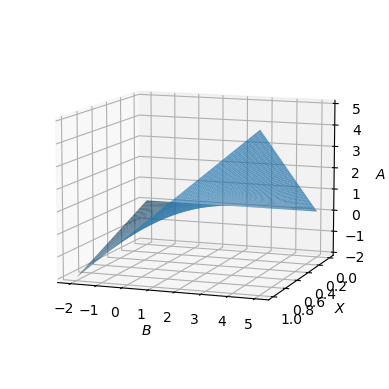

In [115]:
bMin = -2
bMax = 5

def GenerateBilinearGraph(show=True,fig=None,ax=None):
    if fig == None and ax == None:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')

    b = np.linspace(bMin,bMax)
    x = np.linspace(0,1)
    B,X = np.meshgrid(b,x)
    A = B * X

    if show:
        ax.plot_surface(B,X,A,alpha=0.7)
    ax.set_xlabel("$B$")
    ax.set_ylabel("$X$")
    ax.set_zlabel("$A$")
    ax.view_init(elev=10., azim=110)
    ax.invert_xaxis()
    ax.dist = 11
    return fig,ax
GenerateBilinearGraph();

It can make our formulations much faster if we can linearize this somehow.

To do so, it's important to note that, at the end of the optimization, $x$ will either be 0 or 1 (since it's a binary variable).

Thus the only **true** feasible points on this plot are shown below by the black lines.

C:\Users\nb5786-A\AppData\Local\Temp\ipykernel_12756\1852828833.py:21: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 11


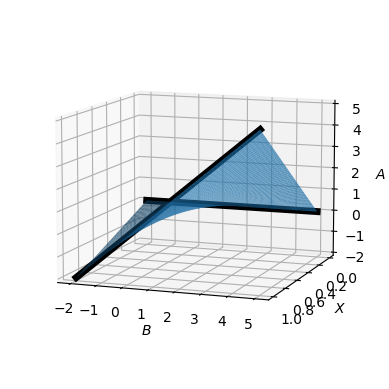

In [116]:
fig,ax = GenerateBilinearGraph()
ax.plot([bMin,bMax],[0,0],[0,0],color="black",linewidth=5)
ax.plot([bMin,bMax],[1,1],[bMin,bMax],color="black",linewidth=5);

If we know the exact bounds of $B$ ($\beta^{MIN}$ and $\beta^{MAX}$), then we can define the convex hull of this relationship that yeilds the correct characteristics at $X = 0$ and $X = 1$.

This convex hull takes the form of a tetrahedron as shown in the figure below.

C:\Users\nb5786-A\AppData\Local\Temp\ipykernel_12756\1852828833.py:21: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 11


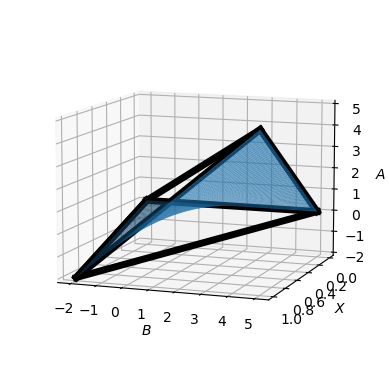

In [117]:
fig,ax = GenerateBilinearGraph()
w = 5
ax.plot([bMin,bMax],[0,0],[0,0],color="black",linewidth=w)
ax.plot([bMin,bMax],[1,1],[bMin,bMax],color="black",linewidth=w)
ax.plot([bMin,bMin],[0,1],[0,bMin],color="black",linewidth=w)
ax.plot([bMin,bMin],[0,1],[0,bMin],color="black",linewidth=w)
ax.plot([bMin,bMax],[0,1],[0,bMax],color="black",linewidth=w)
ax.plot([bMin,bMax],[1,0],[bMin,0],color="black",linewidth=w)
ax.plot([bMax,bMax],[0,1],[0,bMax],color="black",linewidth=w);

Each of the faces of this tetrahedron can be described as a linear constraint.

These faces can be seen in the following 4 plots.

In [118]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
def PlotPlane(p1,p2,p3,ax,**kwargs):
    """
    A function to plot a plane that passes through 3 points.
    """
    ax.add_collection(Poly3DCollection([(p1,p2,p3),],**kwargs))

C:\Users\nb5786-A\AppData\Local\Temp\ipykernel_12756\1852828833.py:21: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 11


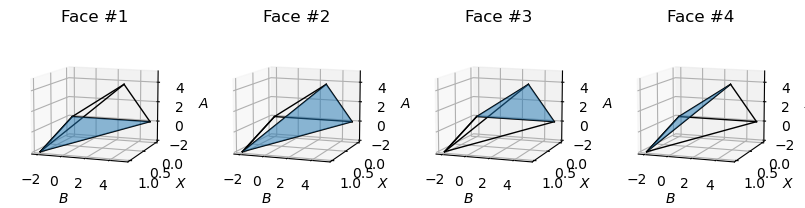

In [119]:
fig = plt.figure(figsize=(10,2.5))
axes = [None,None,None,None]

points = [
    [bMin,0,0],
    [bMax,0,0],
    [bMin,1,bMin],
    [bMax,1,bMax]
]

faces = [
    [0,1,2],
    [1,2,3],
    [0,1,3],
    [0,2,3],
]

for i in range(4):
    ax = fig.add_subplot(1,4,i+1,projection="3d")
    GenerateBilinearGraph(show=False,fig=fig,ax=ax)
    w = 1
    ax.plot([bMin,bMax],[0,0],[0,0],color="black",linewidth=w)
    ax.plot([bMin,bMax],[1,1],[bMin,bMax],color="black",linewidth=w)
    ax.plot([bMin,bMin],[0,1],[0,bMin],color="black",linewidth=w)
    ax.plot([bMin,bMin],[0,1],[0,bMin],color="black",linewidth=w)
    ax.plot([bMin,bMax],[0,1],[0,bMax],color="black",linewidth=w)
    ax.plot([bMin,bMax],[1,0],[bMin,0],color="black",linewidth=w)
    ax.plot([bMax,bMax],[0,1],[0,bMax],color="black",linewidth=w)
    axes[i] = ax

    p = [points[ii] for ii in faces[i]]
    PlotPlane(*p,ax,alpha=0.5)
    ax.set_title(f"Face #{i+1}")

We must now derive the constraint associated with each of these faces.

Do do so, we'll need to consider the equation for a 3-D plane that connects three points.

> Consider three arbitrary points: 
> $$\overline{p}_1 = \begin{bmatrix}p_{1,x}\\p_{1,y}\\p_{1,z}\end{bmatrix}, \overline{p}_2 = \begin{bmatrix}p_{2,x}\\p_{2,y}\\p_{2,z}\end{bmatrix}, \overline{p}_3 = \begin{bmatrix}p_{3,x}\\p_{3,y}\\p_{3,z}\end{bmatrix}$$
> We can define two vectors that lie within the plane formed by these three points:
> $$\overline{v}_1 = \overline{p}_2 - \overline{p}_1, \overline{v}_2 = \overline{p}_3 - \overline{p}_1$$
> The cross product of these vectors yields another vector that is orthogonal to the plane:
> $$\overline{v}_3 = \overline{v}_1 \times \overline{v}_2$$
> The equation for the plane itself has the following form:
> $$v_{3,x}x + v_{3,y}y + v_{3,z}z = k$$
> The final step is to compute the value $k$ by substituting the values of $\overline{p}_1$ into $x$, $y$, and $z$:
> $$k = v_{3,x}p_{1,x} + v_{3,y}p_{1,y} + v_{3,z}p_{1,z} = \overline{v}_3 \cdot \overline{p}_1$$
> The fully-substituted form of the equation is shown in the following cell.

In [85]:
p1x,p1y,p1z,p2x,p2y,p2z,p3x,p3y,p3z = sp.symbols("p_1x,p_1y,p_1z,p_2x,p_2y,p_2z,p_3x,p_3y,p_3z")

p1 = sp.Matrix([
    [p1x,],
    [p1y,],
    [p1z,]
])
p2 = sp.Matrix([
    [p2x,],
    [p2y,],
    [p2z,]
])
p3 = sp.Matrix([
    [p3x,],
    [p3y,],
    [p3z,]
])

v1 = p2 - p1
v2 = p3 - p1

v3 = v1.cross(v2)
k = v3.dot(p1)

k = k.simplify()
v3.simplify()

string = f"\\left({latex(v3[0])}\\right)x + \\\\ \\left({latex(v3[1])}\\right)y + \\\\ \\left({latex(v3[2])}\\right)z  \\\\ = {latex(k)}"

string = "$$\\begin{split} " + string + " \\end{split}"
display(Markdown(string))

$$\begin{split} \left(\left(p_{1y} - p_{2y}\right) \left(p_{1z} - p_{3z}\right) - \left(p_{1y} - p_{3y}\right) \left(p_{1z} - p_{2z}\right)\right)x + \\ \left(- \left(p_{1x} - p_{2x}\right) \left(p_{1z} - p_{3z}\right) + \left(p_{1x} - p_{3x}\right) \left(p_{1z} - p_{2z}\right)\right)y + \\ \left(\left(p_{1x} - p_{2x}\right) \left(p_{1y} - p_{3y}\right) - \left(p_{1x} - p_{3x}\right) \left(p_{1y} - p_{2y}\right)\right)z  \\ = p_{1x} p_{2y} p_{3z} - p_{1x} p_{2z} p_{3y} - p_{1y} p_{2x} p_{3z} + p_{1y} p_{2z} p_{3x} + p_{1z} p_{2x} p_{3y} - p_{1z} p_{2y} p_{3x} \end{split}

For each of the four planes of interest, we can define $\overline{p}_1$, $\overline{p}_2$, and $\overline{p}_3$ as follows.

* Face #1:
$$\overline{p}_1 = \begin{bmatrix}\beta^{MIN}\\0\\0\end{bmatrix}, \overline{p}_2 = \begin{bmatrix}\beta^{MIN}\\1\\\beta^{MIN}\end{bmatrix}, \overline{p}_3 = \begin{bmatrix}\beta^{MAX}\\0\\0\end{bmatrix}$$

* Face #2:
$$\overline{p}_1 = \begin{bmatrix}\beta^{MAX}\\1\\\beta^{MAX}\end{bmatrix}, \overline{p}_2 = \begin{bmatrix}\beta^{MIN}\\1\\\beta^{MIN}\end{bmatrix}, \overline{p}_3 = \begin{bmatrix}\beta^{MAX}\\0\\0\end{bmatrix}$$

* Face #3:
$$\overline{p}_1 = \begin{bmatrix}\beta^{MAX}\\1\\\beta^{MAX}\end{bmatrix}, \overline{p}_2 = \begin{bmatrix}\beta^{MIN}\\0\\0\end{bmatrix}, \overline{p}_3 = \begin{bmatrix}\beta^{MAX}\\0\\0\end{bmatrix}$$

* Face #4:
$$\overline{p}_1 = \begin{bmatrix}\beta^{MAX}\\1\\\beta^{MAX}\end{bmatrix}, \overline{p}_2 = \begin{bmatrix}\beta^{MIN}\\0\\0\end{bmatrix}, \overline{p}_3 = \begin{bmatrix}\beta^{MIN}\\1\\\beta^{MIN}\end{bmatrix}$$

Substituting these points into the equation we derived above produces the following:

In [98]:
x,y,z = sp.symbols("B,X,A")

betaMin,betaMax = sp.symbols("beta^MIN,beta^MAX")

xyz = sp.Matrix([
    [x,],
    [y,],
    [z,]
])

equality = sp.Equality(v3.dot(xyz),k)

faces = {
    "#1": {
        p1x: betaMin,
        p1y: 0,
        p1z: 0,
        p2x: betaMin,
        p2y: 1,
        p2z: betaMin,
        p3x: betaMax,
        p3y: 0,
        p3z: 0
    },
    "#2": {
        p1x: betaMax,
        p1y: 1,
        p1z: betaMax,
        p2x: betaMin,
        p2y: 1,
        p2z: betaMin,
        p3x: betaMax,
        p3y: 0,
        p3z: 0
    },
    "#3": {
        p1x: betaMax,
        p1y: 1,
        p1z: betaMax,
        p2x: betaMin,
        p2y: 0,
        p2z: 0,
        p3x: betaMax,
        p3y: 0,
        p3z: 0
    },
    "#4": {
        p1x: betaMax,
        p1y: 1,
        p1z: betaMax,
        p2x: betaMin,
        p2y: 0,
        p2z: 0,
        p3x: betaMin,
        p3y: 1,
        p3z: betaMin,
    },
}

relations = {f: equality.subs(faces[f]) for f in faces}

for f in faces:
    print(f"Face {f}:")
    display(relations[f])

Face #1:


Eq(A*(-beta^MAX + beta^MIN) - X*beta^MIN*(-beta^MAX + beta^MIN), 0)

Face #2:


Eq(A*(beta^MAX - beta^MIN) - B*(beta^MAX - beta^MIN) - X*beta^MAX*(beta^MAX - beta^MIN), -beta^MAX**2 + beta^MAX*beta^MIN)

Face #3:


Eq(A*(beta^MAX - beta^MIN) - X*beta^MAX*(beta^MAX - beta^MIN), 0)

Face #4:


Eq(A*(-beta^MAX + beta^MIN) + B*(beta^MAX - beta^MIN) + X*(beta^MAX*(beta^MAX - beta^MIN) - (beta^MAX - beta^MIN)**2), beta^MAX*beta^MIN - beta^MIN**2)

For readability we'll re-arrange these to be of the form $A = ...$

In [99]:
for f in faces:
    print(f"Face {f}:")
    aSol = sp.solve(relations[f],z)[0]
    str = f"$A = {latex(aSol)}$"
    display(Markdown(str))

Face #1:


$A = X \beta^{MIN}$

Face #2:


$A = B + X \beta^{MAX} - \beta^{MAX}$

Face #3:


$A = X \beta^{MAX}$

Face #4:


$A = B + X \beta^{MIN} - \beta^{MIN}$

These equations form define the faces of the tetrahedron.

However, to define the feasible space inside the tetrahedron, A must be **greater than** the first two faces and  **less than** the second two faces.

Thus, we arrive at the following result:

* Face #1:
$$A \geq \beta^{MIN}X$$

* Face #2:
$$A \geq B + \beta^{MAX}(X - 1)$$

* Face #3:
$$A \leq \beta^{MAX}X$$

* Face #4:
$$A \leq B + \beta^{MIN}(X - 1)$$

To add one simple layer of complexity, let's now consider the relationship

$$A = BX + C$$

Let's introduce a new variable $D = A - C$

Thus,

$$A - C = D = BX$$

Treating $D$ as we have $A$ in the prior derivation shows that this relationship can be modeled as 
$$D \geq \beta^{MIN}X$$
$$D \geq B + \beta^{MAX}(X - 1)$$
$$D \leq \beta^{MAX}X$$
$$D \leq B + \beta^{MIN}(X - 1)$$

By re-substituting the definition of $D$ into each of these inequalities and adding $C$ to both sides, we get that

$$A = BX + C$$

can be linearly modeled as

$$A \geq \beta^{MIN}X + C$$
$$A \geq B + \beta^{MAX}(X - 1) + C$$
$$A \leq \beta^{MAX}X + C$$
$$A \leq B + \beta^{MIN}(X - 1) + C$$